In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

from scipy.stats import uniform,randint

In [10]:
from xgboost import XGBRegressor

# Some function

In [66]:
def prediction(model):
    y_pred = model.predict(Xv_process)
    rmse = np.sqrt(mean_squared_error(y_val,y_pred))
    print(f"rmse for {str(model)} : ",round(rmse,2))
    
def scaling(Xt,Xv):
    scaler = StandardScaler()
    return (scaler.fit_transform(X),scaler.transform(Xv))

In [48]:
df = pd.read_csv("data/train.csv",index_col="id")

In [49]:
df.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [4]:
df.shape

(5407, 10)

## Data exploration

<AxesSubplot:>

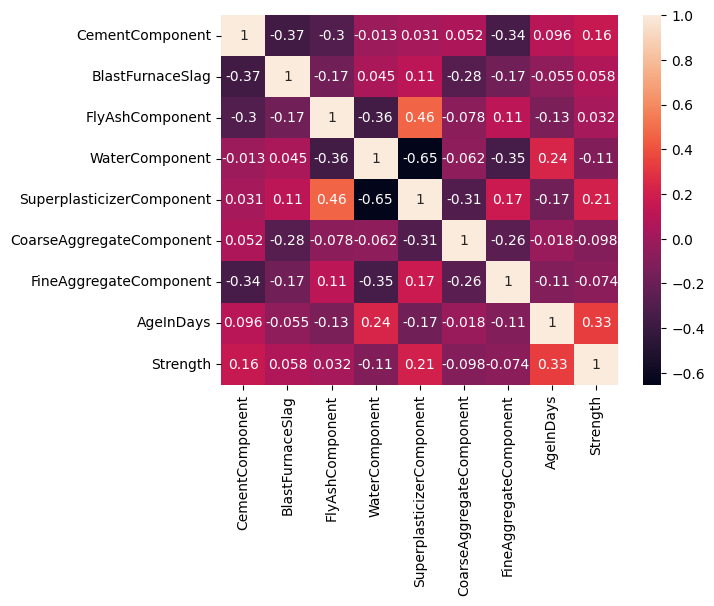

In [57]:
sns.heatmap(df.corr(),annot=True)

# ML logic

## Preprocessing

In [50]:
X = df.drop("Strength",axis=1)
y = df["Strength"]

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [51]:
scale = StandardScaler()

Xt_process = scale.fit_transform(X_train)
Xv_process = scale.transform(X_val)

## Baseline rmse

In [52]:
y_pred = np.full(shape=y_val.shape,fill_value=y_val.mean())
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
print("rmse for baseline : ",round(rmse,2))

rmse for baseline :  16.5


## Xgboost

### Base parameter

In [53]:
xgb = XGBRegressor()
xgb.fit(Xt_process,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [54]:
y_pred = xgb.predict(Xv_process)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
print("rmse for xgboost : ",round(rmse,2))

rmse for xgboost :  12.66


### Randomsearch on xgboost

In [55]:
params = {
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'max_depth': range(1, 10),
    'n_estimators': range(50, 1000, 50),
    'subsample': np.linspace(0.1, 1.0, 10),
    'colsample_bytree': np.linspace(0.1, 1.0, 10),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10),
    'gamma': np.linspace(0, 1, 10)
}

rndsearch = RandomizedSearchCV(xgb,param_distributions=params,n_iter=200,cv=5,verbose=1,n_jobs=-1)
rndsearch.fit(Xt_process,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_bin=256, m...
                                        'max_depth': range(1, 10),
                                        'n_estimators': range(50, 1000, 50),
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   verbose=1)

In [25]:
print(rndsearch.best_params_)

{'subsample': 0.6, 'reg_lambda': 0.4444444444444444, 'reg_alpha': 0.0, 'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.052222222222222225, 'gamma': 0.4444444444444444, 'colsample_bytree': 0.7000000000000001}


In [23]:
best_params = [{'subsample': 0.6, 'reg_lambda': 0.7777777777777777, 'reg_alpha': 0.7777777777777777, 'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.052222222222222225, 'gamma': 0.8888888888888888, 'colsample_bytree': 0.5}]

In [56]:
xgb_best = rndsearch.best_estimator_
y_pred = xgb_best.predict(Xv_process)
np.sqrt(mean_squared_error(y_val,y_pred))

11.827922764008312

## Ridge model

### Base hyperparameter

In [37]:
ridge = Ridge()

ridge.fit(Xt_process,y_train)

y_pred = ridge.predict(Xv_process)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
print("rmse for ridge : ",round(rmse,2))

rmse for ridge :  14.39


### Hyperparameter tuning

In [46]:
params =  {'alpha': uniform(0, 10),
            'fit_intercept': [True, False],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

rnd_search = RandomizedSearchCV(ridge,param_distributions=params,cv=5,verbose=1,n_iter=100,n_jobs=-1)

rnd_search.fit(Xt_process,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36afc0aec0>,
                                        'fit_intercept': [True, False],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga']},
                   verbose=1)

In [45]:
ridge_best = rnd_search.best_estimator_
y_pred = ridge_best.predict(Xv_process)
np.sqrt(mean_squared_error(y_val,y_pred))

14.395400199735342

# Testing without specific column

In [59]:
X = df.drop(["Strength","WaterComponent","SuperplasticizerComponent"],axis=1)
y = df["Strength"]

In [60]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

scale = StandardScaler()

Xt_process = scale.fit_transform(X_train)
Xv_process = scale.transform(X_val)

## Testing Xgboost

In [62]:
xgb = XGBRegressor()
xgb.fit(Xt_process,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [67]:
prediction(xgb)

rmse for XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) :  12.55


In [76]:
params = {
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(1, 10),
    'n_estimators': randint(50, 1000),
    'subsample': uniform(0.1, 0.9),
    'colsample_bytree':uniform(0.1, 0.9),
    'reg_alpha': uniform(0, 1),
    'reg_lambda':uniform(0, 1),
    'gamma': uniform(0, 1)
}

rndsearch = RandomizedSearchCV(xgb,param_distributions=params,n_iter=200,cv=5,verbose=1,n_jobs=-1)
rndsearch.fit(Xt_process,y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_bin=256, m...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36e2ecaf20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36e2f29000>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36624de410>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36e2f6bbb0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f36624de890>},
                   verbose=1)

In [75]:
xgb_best = rndsearch.best_estimator_

prediction(xgb_best)

rmse for XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7525773496686682, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.5999865133861448, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.031893542622895316, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=3, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=189, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.8804001494196181,
             reg_lambda=0.15443342376148583, ...) :  11.93
